# Book Recommender
Purpose: to explore topics in Information Retrieval and RAG.

## Environment Setup

In [1]:
%%capture

# installations
!pip install --quiet sentence_transformers transformers torch peft huggingface_hub kaggle pinecone lark rank_bm25 langchain_huggingface langdetect langchain_experimental 

# THE REGS
import pandas as pd
import numpy as np
import kagglehub
import torch
import nltk
import string
import os
import time
import re

# NLP
import nltk
from langdetect import detect, DetectorFactory

# Transformers
from transformers import AutoTokenizer, AutoModel
import torch

# PINECONE
from pinecone import Pinecone
from pinecone import ServerlessSpec

# LANGCHAIN
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_experimental.text_splitter import SemanticChunker

# Kaggle environment
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

## Data Setup

In [4]:
# Reformat data file so it fits into a pandas dataframe
def text_to_csv_pandas(input_file, output_file, column_names, delimiter=None):
    """
    Reads a text file into a Pandas DataFrame and saves it as a CSV file.

    Args:
        input_file (str): The path to the input text file.
        output_file (str): The path to the output CSV file.
        delimiter (str, optional): The delimiter used in the text file. Defaults to None, 
        which will split each line by whitespace if the text file is not delimited.
    """
    if delimiter is not None:
        df = pd.read_csv(input_file, sep=delimiter, names = column_names, header=None)
    else:
         df = pd.read_csv(input_file, sep=r'\s+', names = column_names, header=None)
    df.to_csv(output_file, index=False, header=True)

# Columns in the data set
columns = ['Wikipedia article ID', 
           'Freebase ID', 
           'Book title', 
           'Author', 
           'Publication date', 
           'Book genres', 
           'Plot summary']

text_to_csv_pandas('/kaggle/input/cmu-book-summary-dataset/booksummaries.txt', 'data.csv', 
                   column_names = columns, delimiter='\t')

data = pd.read_csv('/kaggle/working/data.csv')

# drop the ID columns
data.drop(columns=['Wikipedia article ID', 'Freebase ID'], inplace=True)

# preview
data.head(n=3)

,Book title,Author,Publication date,Book genres,Plot summary
0,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...


## Data Cleaning

In [5]:
print("Number of NA values for each feature:\n", data.isna().sum())

Number of NA values for each feature:
 Book title             0
Author              2382
Publication date    5610
Book genres            0
Plot summary           0
dtype: int64


### Genre Column
* Remove brackets
* Remove /m/ char sequences
* Fix utf-8 symbols
* Put genres in list format for each cell

In [6]:
# CLEAN GENRE COLUMN

# Find all genres in cell block, do not keep char sequences that begin with /m/
data['Book genres'] = data['Book genres'].apply(lambda row: re.findall(r'":\s*"([^"]+)"', str(row)))

# take care of utf-8 symbols as well (ex. \\u00e0)
data['Book genres'] = data['Book genres'].apply(lambda cell: [bytes(word, "utf-8").decode("unicode_escape") for word in cell])

# Preview
data.head(n=3)

,Book title,Author,Publication date,Book genres,Plot summary
0,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...


### Publication date column
* The majority of the books half the publication year, therefore we will create a new column for it.

In [9]:
# regex to find dates that only contain the year
regex = r'\d{4}$'
year_only_dates = data[data['Publication date'].str.contains(regex) == True].index
print("Number of books with only the publication year: ", len(year_only_dates))

# regex to find dates that only contain year and month
regex = r'\d{4}-\d{2}$'
half_dates = data[data['Publication date'].str.contains(regex) == True].index
print("Number of books with just the year and month: ", len(half_dates))

# regex to find complete dates
regex = r'\d{4}-\d{2}-\d{2}'
full_dates = data[data['Publication date'].str.contains(regex) == True].index
print("Number of books with the full publication date: ", len(full_dates))

Number of books with no publication date:  5610
Number of books with only the publication year:  6799
Number of books with just the year and month:  1479
Number of books with the full publication date:  2671


In [10]:
# CREATE NEW COLUMN FOR PUBLICATION YEAR

# New column for publication year
data['Publication year'] = 0

# Fill in column with year values
data.loc[full_dates, 'Publication year'] = data.loc[full_dates, 'Publication date'].str.split("-").str[0].astype('int')
data.loc[half_dates, 'Publication year'] = data.loc[half_dates, 'Publication date'].str.split("-").str[0].astype('int')
data.loc[year_only_dates, 'Publication year'] = data.loc[year_only_dates, 'Publication date'].str.split("-").str[0].astype('int')

# Preview
data.head(n=3)

,Book title,Author,Publication date,Book genres,Plot summary,Publication year
0,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca...",1945
1,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan...",1962
2,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...,1947


### Plot summary column
* Remove books with no proper description of the plot.

In [14]:
# get number of words per plot summary
words_per_summary = data['Plot summary'].apply(lambda x: len(nltk.word_tokenize(x)))

In [17]:
data.loc[words_per_summary[words_per_summary < 10].index]

,Book title,Author,Publication date,Book genres,Plot summary,Publication year
2045,The Kennel Murder Case,S. S. Van Dine,NaN,"[Mystery, Fiction, Suspense]",~Plot outline description,0
3879,Slavers,Chris Pramas,2000,[Role-playing game],==Publication histor,2000
5271,Golem in the Gears,Piers Anthony,1986-02,"[Science Fiction, Speculative fiction, Fantasy...",pl:Zakochany golem,1986
5595,The Adventures of Super Diaper Baby,Dav Pilkey,2002,[Children's literature],=== Plot summary ===,2002
5693,The Deathlord of Ixia,John Grant,1992,"[Gamebook, Speculative fiction, Children's lit...",==Receptio,1992
5879,The Caverns of Kalte,Joe Dever,1984,"[Gamebook, Speculative fiction, Fantasy, Child...",==Receptio,1984
5972,The Eyes of Darkness,Dean Koontz,1981,"[Speculative fiction, Horror, Fiction, Romance...",==Character,1981
6335,Created By,Richard Christian Matheson,1993,"[Speculative fiction, Horror, Fiction]",~Plot outline description,1993
6622,The Saint in Pursuit,Leslie Charteris,1970,[Mystery],To be added.,1970
6629,The Saint and the Hapsburg Necklace,Leslie Charteris,1976,"[Mystery, Suspense]",To be added.,1976


In [25]:
# Regex pattern (e.g., any row containing 'apple' or 'grape')
pattern = r'=='

# Find matching indices
data[data['Plot summary'].str.contains(pattern, regex=True)]

,Book title,Author,Publication date,Book genres,Plot summary,Publication year


Since there are multiple valid plot summaries that have 2+ equal signs, we will need to remove them.

In [24]:
# Replace substrings with 2+ equal signs
data['Plot summary'] = data['Plot summary'].str.replace(r'={2,}', '', regex=True)

In [27]:
# drop rows that have 5 terms or less
data.drop(words_per_summary[words_per_summary < 6].index.tolist(), inplace=True)

# drop rows that contain "Plot outline description" 
data.drop(data[data['Plot summary'].str.contains(pattern, regex=True)].index.tolist(), inplace=True)

# dropping rows does not automatically reset index. So we must do this manually.
data.reset_index(drop=True, inplace=True)

In [34]:
# DELETE BOOKS THAT ARE NOT IN ENGLISH
DetectorFactory.seed = 0  # for consistent results

def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except Exception as e:
        return f"Error: {str(e)}"

langs = data['Plot summary'].apply(lambda x: detect_language(x))
eng_books = langs[langs == 'en'].index

print("Number of english summaries in dataset: ", len(eng_books))

data = data.loc[eng_books]
data.reset_index(drop=True, inplace=True)

Number of english summaries in dataset:  16512


In [35]:
# Check to see if there are any other common things that do not add to the summary that I should remove (for embeddings)
data['Plot summary'][0]

' Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, \'Beasts of England\'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a philosophy. The animals revolt and drive the drunken and irresponsible Mr Jones from the farm, renaming it "Animal Farm". They adopt Seven Commandments of Animal-ism, the most important of which is, "All animals are equal". Snowball attempts to teach the animals reading and writing; food is plentiful, and the farm runs smoothly. The pigs elevate themselves to positions of leadership and set aside special food items, ostensibly for their personal health. Napoleon takes the pups from the farm dogs and trains them privately. Napoleon and Snowball struggle for leadership. When Snowball announces his plans to build a windmill, Napoleon has his dogs chase Snowball away and declares himself leader. N

In [36]:
data['Plot summary'] = data['Plot summary'].apply(lambda x: x.replace('#', ''))
data['Plot summary'] = data['Plot summary'].apply(lambda x: x.replace('*', ''))

## How Embeddings Operate
Model: https://huggingface.co/BAAI/bge-m3

**Encoding**:
* This is a broad term that refers to the process of transforming data from one format to another. Examples include converting text into binary format, converting characters to numerical values, or compressing data. [[1]](https://medium.com/@pratiyush1/understanding-different-types-of-encoding-and-decoding-in-programming-with-practical-examples-dcbdd5215605#:~:text=Practical%20Example%201:%20Email%20Attachments%20Base64%20encoding,were%20traditionally%20designed%20to%20handle%20text%2Donly%20data)
  
**Tokenization**:
* In the context of natural language processing (NLP), tokenization is a specific type of encoding where text is broken down into smaller units called tokens. These tokens can be words, characters, or even sub-word units. [[2]](https://www.datacamp.com/blog/what-is-tokenization#:~:text=Training%20more%20people?,which%20are%20easier%20to%20analyze)

**Embeddings**:
* are advanced vector representations of tokens. They try to capture the most nuance, connections, and semantic meanings between tokens. Each embedding is generally a series of real numbers on a vector space computed by a neural network. [[3]](https://medium.com/the-research-nest/explained-tokens-and-embeddings-in-llms-69a16ba5db33)


> In short, text is converted to tokens. Tokens are assigned token IDs. These token IDs can be used to create embeddings for more nuanced numerical representation in complex models.
>
> Why are embeddings so large and complex? What do they signify?
>
> Each token’s embedding is a high-dimensional vector. This allows the model to capture a wide range of linguistic features and nuances, like the meaning of a word, its part of speech, and its relationship to other words in the sentence.
>
> * Contextual Embeddings: Unlike simpler word embeddings (like Word2Vec), BERT’s embeddings are contextual. This means the same word can have different embeddings based on its context (its surrounding words). The embeddings need to be rich and complex to capture this contextual nuance.
> 
> * In more complex models like BERT, you get the final embeddings and access to the embeddings from each layer of the neural network. Each layer captures different aspects of the language, adding to the complexity and size of the tensor.
>
> * Input for Further Tasks: These embeddings are used as input for various NLP tasks like sentiment analysis, question answering, and language translation. The richness of the embeddings allows the model to perform these tasks with a high degree of sophistication.
>
> * Model’s Internal Representation: The complexity of these tensors reflects how the model ‘understands’ language. Each dimension in the embedding can represent some abstract language feature the model learned during its training.
> [[3]](https://medium.com/the-research-nest/explained-tokens-and-embeddings-in-llms-69a16ba5db33)

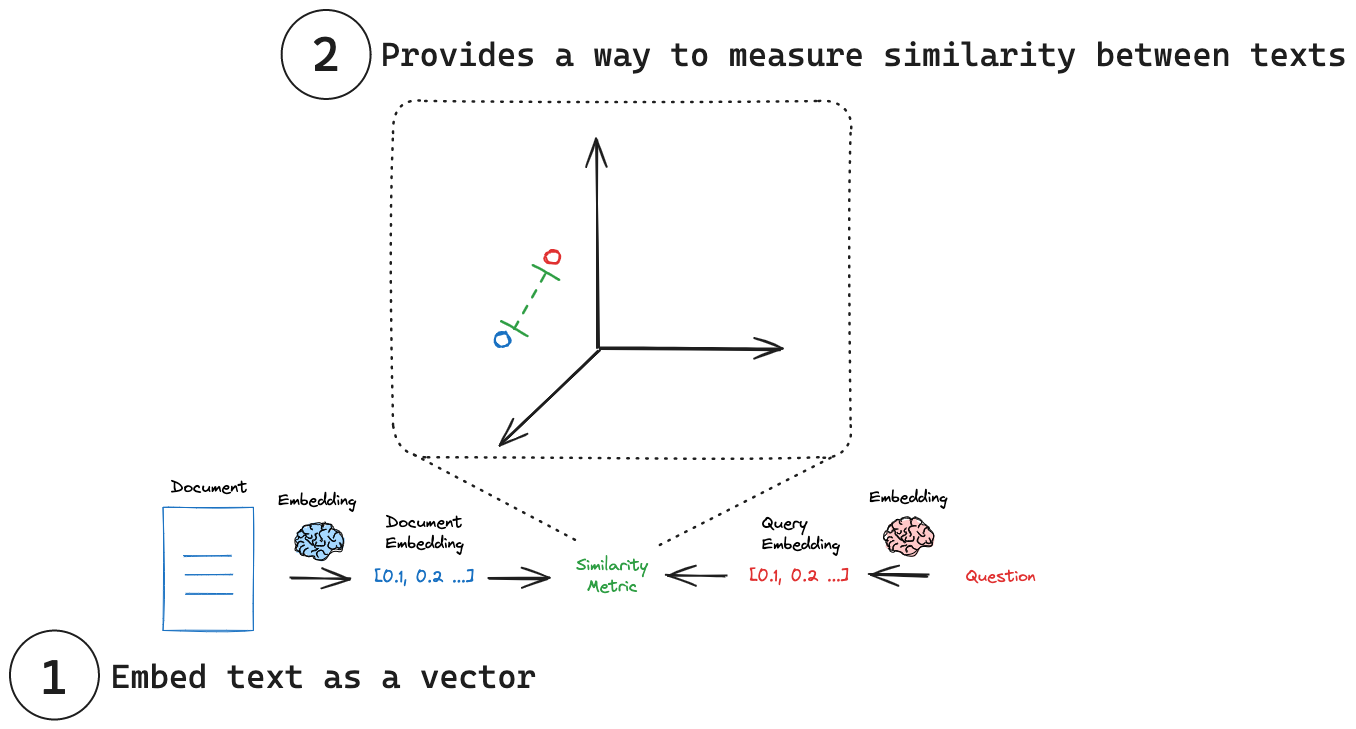 [[4]](https://python.langchain.com/docs/concepts/embedding_models/)
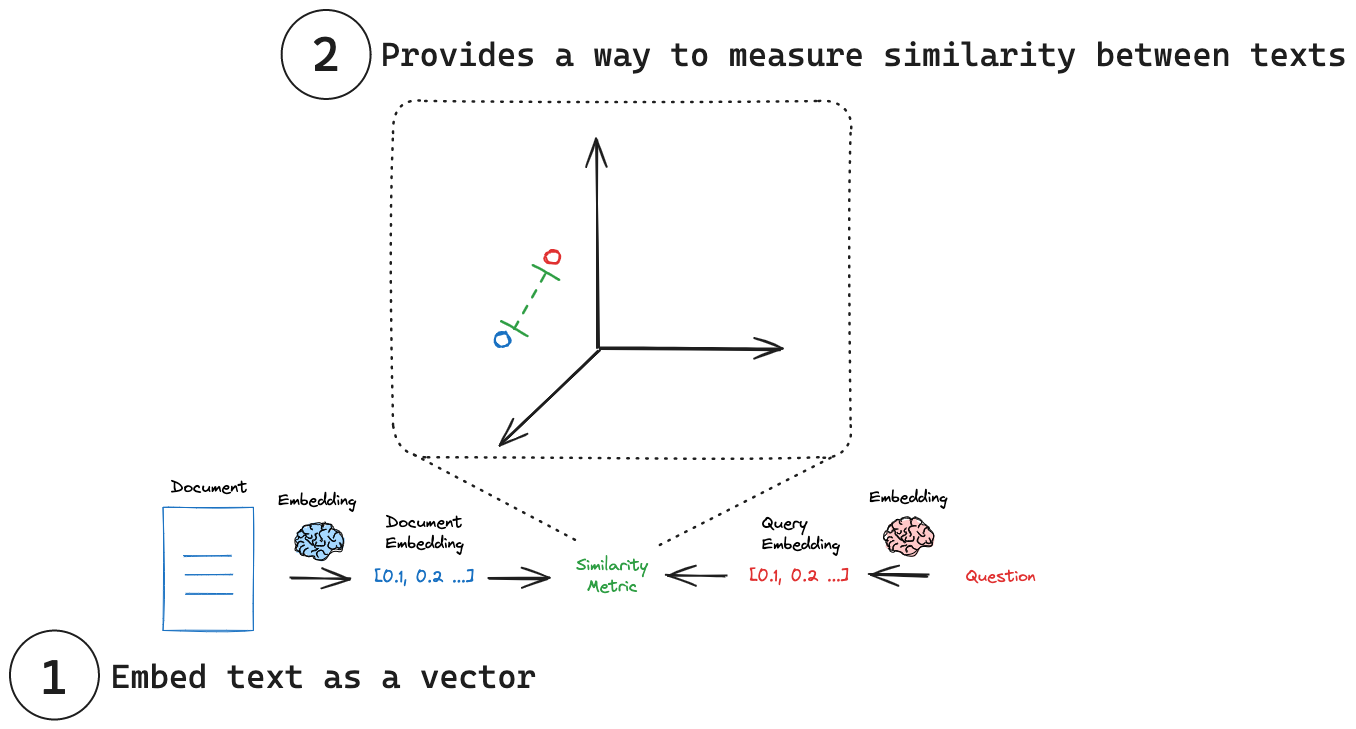

### Step 1: Download an open-source LLM (HuggingFace has many)
* Download the model's tokenizer/encoder as well.

In [30]:
# Get model
model_name = "BAAI/bge-large-zh-v1.5"
model = AutoModel.from_pretrained(model_name)

print("About the model: \n\n", model.eval(), "\n")

# Get corresponding tokenizer/encoder
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("About the tokenizer: \n\n", tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

2025-06-24 18:36:49.713725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750790210.006213      64 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750790210.089816      64 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

About the model: 

 BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropo

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/439k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

About the tokenizer: 

 BertTokenizerFast(name_or_path='BAAI/bge-large-zh-v1.5', vocab_size=21128, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [31]:
test = tokenizer("This is a test")
test

{'input_ids': [101, 8554, 8310, 143, 10060, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

### Step 2: Create an embedder function 

In [32]:
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
embedder = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

print(embedder)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/30.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

model_name='BAAI/bge-large-zh-v1.5' cache_folder=None model_kwargs={'device': 'cpu'} encode_kwargs={'normalize_embeddings': True} query_encode_kwargs={} multi_process=False show_progress=False


### Step 3: Create a text splitter
Why: because embeddings can lose information when input text is too large. 
[[5]](https://python.langchain.com/docs/concepts/text_splitters/)

If you have good computational power, try: LangChain's semantic chunker 


> **Breakpoints**
>
> This chunker works by determining when to "break" apart sentences. This is done by looking for differences in embeddings between any two sentences. When that difference is past some threshold, then they are split.
>
> There are a few ways to determine what that threshold is, which are controlled by the breakpoint_threshold_type kwarg.
>
> Note: if the resulting chunk sizes are too small/big, the additional kwargs breakpoint_threshold_amount and min_chunk_size can be used for adjustments.
>
> **Percentile**
>
> The default way to split is based on percentile. In this method, all differences between sentences are calculated, and then any difference greater than the X percentile is split. The default value for X is 95.0 and can be adjusted by the keyword argument breakpoint_threshold_amount which expects a number between 0.0 and 100.0.
>
> [[6]](https://python.langchain.com/docs/how_to/semantic-chunker/)


In [33]:
# This is a long document we can split up.
test = data['Plot summary'][0]    

text_splitter = SemanticChunker(embedder, breakpoint_threshold_type="percentile")

docs = text_splitter.create_documents([test])
print(docs[3].page_content)
print("\nNumber of splits created from this document: ", len(docs))

6 No animal shall kill any other animal without cause. Eventually these are replaced with the maxims, "All animals are equal, but some animals are more equal than others", and "Four legs good, two legs better!" as the pigs become more human. This is an ironic twist to the original purpose of the Seven Commandments, which were supposed to keep order within Animal Farm by uniting the animals together against the humans, and prevent animals from following the humans' evil habits. Through the revision of the commandments, Orwell demonstrates how simply political dogma can be turned into malleable propaganda.

Number of splits created from this document:  4


**Eco-friendly option: The character text splitter**


> Text-structured based
>
> Text is naturally organized into hierarchical units such as paragraphs, sentences, and words. We can leverage this inherent structure to inform our splitting strategy, creating split that maintain natural language flow, maintain semantic coherence within split, and adapts to varying levels of text granularity. LangChain's RecursiveCharacterTextSplitter implements this concept:
> The RecursiveCharacterTextSplitter attempts to keep larger units (e.g., paragraphs) intact.
> If a unit exceeds the chunk size, it moves to the next level (e.g., sentences).
> This process continues down to the word level if necessary.
>
> [[7]](https://python.langchain.com/docs/concepts/text_splitters/)


**More about Document object in Langchain:** https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html

In [49]:
%%time
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)

split_plot_summaries = data['Plot summary'].apply(lambda x: text_splitter.create_documents([x]))

split_plot_summaries.head(3)

CPU times: user 7.94 s, sys: 40.6 ms, total: 7.98 s
Wall time: 7.98 s


In [51]:
num_splits_per_summary = split_plot_summaries.apply(len)
num_splits_per_summary.describe()

In [55]:
fig = px.histogram(num_splits_per_summary)
fig.update_layout(
    xaxis_title="Number of splits per book plot summary",
    yaxis_title="Count of books",   
)
fig.show()

### Step 4: VectorStore setup

In [57]:
# setting up pinecone env (index created in Pinecone)
pc = Pinecone(api_key=user_secrets.get_secret("PINECONE_API_KEY"))
index_name = "recommend-me-vector-store"
index = pc.Index(index_name)

print("Index statistics:\n\n", index.describe_index_stats())

Index statistics:

 {'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}


### Step 5: Use the text splits & embedder to upload vectors to Pinecone

In [ ]:
# Create Main Namespace

# add vectors to pinecone using embed function
db = PineconeVectorStore.from_documents(documents=splits,
                                        embedding=embedder, # note: embedder also handles tokenizing so we do not need a separate process
                                        index_name=index_name,
                                        namespace="main"
                                        )

In [ ]:
import openai
import pinecone
from sentence_transformers import SentenceTransformer
import os

# Set up API keys
openai.api_key = "your-openai-api-key"
pinecone.init(api_key="your-pinecone-api-key", environment="us-west1-gcp")

# Initialize the Sentence-Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # You can use any pre-trained model

# Connect to your Pinecone index (replace with your actual index name)
index_name = "document-index"
index = pinecone.Index(index_name)

# Sample documents (you can replace this with loading documents from files or other sources)
documents = [
    {"id": "1", "text": "Python is an amazing programming language."},
    {"id": "2", "text": "Pinecone is a vector database for similarity search."},
    {"id": "3", "text": "Embedding models transform text into numeric vectors."}
]

# Process and embed documents
def embed_documents(documents):
    # List to store the embeddings and metadata to add to Pinecone
    vectors = []
    
    for doc in documents:
        # Create an embedding for the document
        embedding = model.encode(doc["text"]).tolist()  # Convert to list for Pinecone compatibility
        # Add embedding and metadata to vectors
        vectors.append({
            'id': doc['id'],         # Document ID
            'values': embedding,     # The embedding vector
            'metadata': {'text': doc['text']}  # Optional metadata (e.g., the original text)
        })
    
    return vectors

# Add embeddings to Pinecone
def add_to_pinecone(vectors):
    index.upsert(vectors)  # Upload vectors to Pinecone

# Main process
def process_and_upload_documents():
    vectors = embed_documents(documents)
    add_to_pinecone(vectors)
    print("Documents have been embedded and added to Pinecone.")

# Run the process
process_and_upload_documents()


## RAG Pipeline
* include prompt engineering